In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
from PIL import Image
import random
from torchvision.utils import save_image
from pathlib import Path
import itertools
from tqdm import tqdm
from matplotlib import pyplot as plt
import json
from datetime import datetime
from collections import defaultdict
from torch.cuda.amp import GradScaler, autocast

In [ ]:
class SketchDataset(Dataset):
    def __init__(self, bad_root, good_root, samples_per_class=None, fraction=None):
        self.bad_root = Path(bad_root)
        self.good_root = Path(good_root)
        self.transform_bad = transforms.Compose(
            [
                transforms.Grayscale(),
                transforms.Resize((256, 256)),
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.5], std=[0.5]),
            ]
        )

        self.transform_augmented = transforms.Compose(
            [
                transforms.Grayscale(),
                transforms.Resize((256, 256)),
                transforms.RandomHorizontalFlip(0.5),
                transforms.RandomAffine(
                    10,
                    shear=10,
                    scale=(0.8, 1.2),
                    fill=255,
                    interpolation=transforms.InterpolationMode.BILINEAR,
                ),
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.5], std=[0.5]),
            ]
        )

        # Get all classes (folders)
        self.classes = sorted([d.name for d in self.bad_root.iterdir() if d.is_dir()])
        self.class_to_idx = {cls: idx for idx, cls in enumerate(self.classes)}

        # Collect all image paths and their classes
        self.bad_images = []
        self.good_images = []

        for class_name in self.classes:
            bad_class_path = self.bad_root / class_name
            good_class_path = self.good_root / class_name

            bad_class_images = list(bad_class_path.glob("*.png"))
            good_class_images = list(good_class_path.glob("*.png"))

            class_idx = self.class_to_idx[class_name]

            self.bad_images.extend([(str(img), class_idx) for img in bad_class_images])
            self.good_images.extend(
                [(str(img), class_idx) for img in good_class_images]
            )

        # Ensure we have images
        assert len(self.bad_images) > 0, "No bad sketches found"
        assert len(self.good_images) > 0, "No good sketches found"

        if samples_per_class is not None or fraction is not None:
            # Group bad images by class
            class_to_images = defaultdict(list)
            for img_path, class_idx in self.bad_images:
                class_to_images[class_idx].append((img_path, class_idx))

            # Create subset based on specified criterion
            subset_images = []
            for class_idx, images in class_to_images.items():
                if samples_per_class is not None:
                    # Take exact number of samples per class
                    n_samples = min(samples_per_class, len(images))
                elif fraction is not None:
                    # Take fraction of samples per class
                    n_samples = max(1, int(len(images) * fraction))
                else:
                    n_samples = len(images)

                # Randomly sample from this class
                subset_images.extend(random.sample(images, n_samples))

            # Replace bad_images with subset
            self.bad_images = subset_images

    def __getitem__(self, index):
        # Get a bad sketch
        bad_path, bad_class = self.bad_images[index % len(self.bad_images)]

        # Randomly select a good sketch from the same class
        good_candidates = [
            (path, cls) for path, cls in self.good_images if cls == bad_class
        ]
        good_path, good_class = random.choice(good_candidates)

        # Load and transform images
        bad_img = Image.open(bad_path)
        good_img = Image.open(good_path)

        bad_img = self.transform_bad(bad_img)
        good_img = self.transform_augmented(good_img)

        return {"bad": bad_img, "good": good_img, "class": torch.tensor(bad_class)}

    def __len__(self):
        return len(self.bad_images)

    def get_class_distribution(self):
        """
        Returns the distribution of samples across classes.

        Returns:
            dict: Dictionary mapping class names to number of samples
        """
        distribution = defaultdict(int)
        for _, class_idx in self.bad_images:
            class_name = self.classes[class_idx]
            distribution[class_name] += 1
        return dict(distribution)


sketch_dataset = SketchDataset(
    "Datasets/good_sketches//",
    "Datasets/bad_sketches//",
    samples_per_class=500,
)

In [3]:
len(sketch_dataset)

6000

In [4]:
batchsize = 64
test_split = 0.2
val_split = 0.1

train_set, test_set = random_split(
    sketch_dataset,
    [
        round(len(sketch_dataset) * (1 - test_split)),
        round(len(sketch_dataset) * test_split),
    ],
)
train_set, val_set = random_split(
    train_set,
    [round(len(train_set) * (1 - val_split)), round(len(train_set) * val_split)],
)

train_loader = DataLoader(train_set, batch_size=batchsize, shuffle=True)
val_loader = DataLoader(val_set, batch_size=batchsize, shuffle=True)
test_loader = DataLoader(test_set, batch_size=batchsize, shuffle=False)

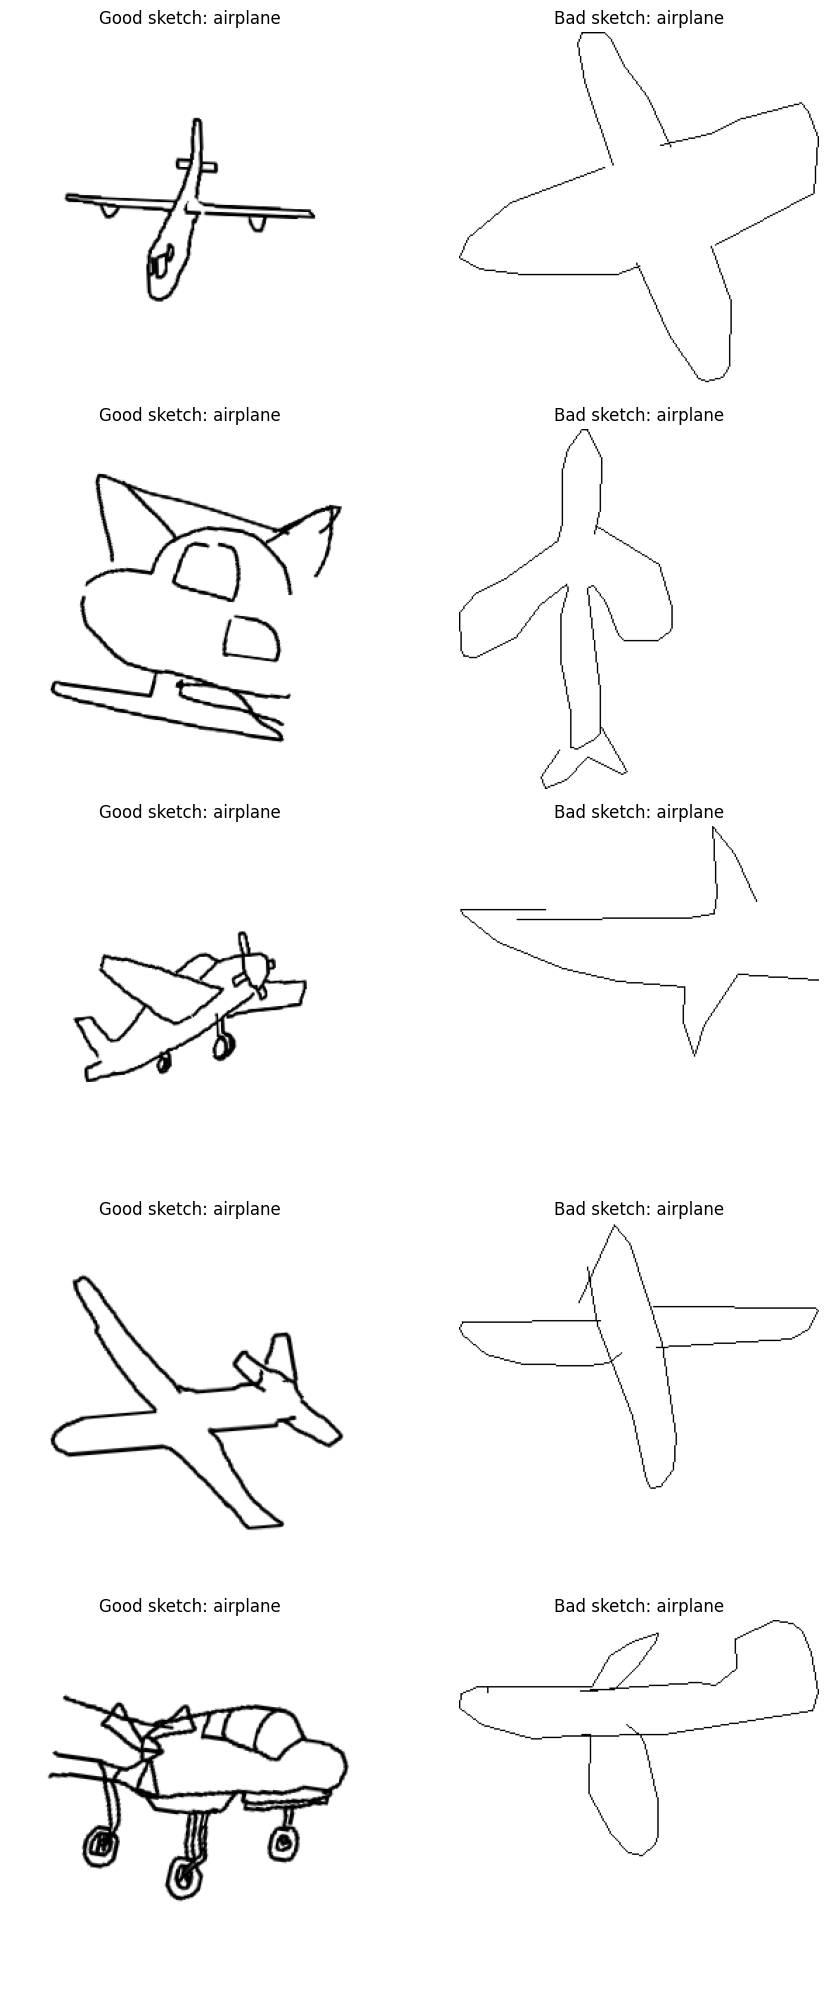

In [5]:
transform_back = transforms.Compose(
    [transforms.Normalize(mean=[-1], std=[2]), transforms.ToPILImage()]
)
fig, axs = plt.subplots(5, 2, figsize=(10, 20))
axs: list[list[plt.Axes]]
for i in range(5):
    sample = sketch_dataset[i]
    good, bad, class_idx = sample["good"], sample["bad"], sample["class"]
    axs[i][0].imshow(transform_back(good), cmap="gray")
    axs[i][1].imshow(transform_back(bad), cmap="gray")
    axs[i][0].set_title(f"Good sketch: {sketch_dataset.classes[class_idx]}")
    axs[i][1].set_title(f"Bad sketch: {sketch_dataset.classes[class_idx]}")
    axs[i][0].axis("off")
    axs[i][1].axis("off")
plt.tight_layout()
plt.show()

In [6]:
class ResBlock(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.conv_block = nn.Sequential(
            nn.Conv2d(dim, dim, kernel_size=3, padding=1),
            nn.InstanceNorm2d(dim),
            nn.ReLU(),
            nn.Conv2d(dim, dim, kernel_size=3, padding=1),
            nn.InstanceNorm2d(dim),
        )

    def forward(self, x):
        return x + self.conv_block(x)


class Generator(nn.Module):
    def __init__(self, num_classes=12):
        super().__init__()
        self.num_classes = num_classes

        # Class embedding
        self.class_embedding = nn.Embedding(num_classes, 64)

        # Initial convolution
        self.init_conv = nn.Sequential(
            nn.Conv2d(1 + 64, 64, kernel_size=7, padding=3),
            nn.InstanceNorm2d(64),
            nn.ReLU(),
        )

        # Downsampling
        self.down1 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
            nn.InstanceNorm2d(128),
            nn.ReLU(),
        )
        self.down2 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1),
            nn.InstanceNorm2d(256),
            nn.ReLU(),
        )

        # Residual blocks
        self.res_blocks = nn.ModuleList([ResBlock(256) for _ in range(6)])

        # Upsampling
        self.up1 = nn.Sequential(
            nn.ConvTranspose2d(
                256, 128, kernel_size=3, stride=2, padding=1, output_padding=1
            ),
            nn.InstanceNorm2d(128),
            nn.ReLU(),
        )
        self.up2 = nn.Sequential(
            nn.ConvTranspose2d(
                128, 64, kernel_size=3, stride=2, padding=1, output_padding=1
            ),
            nn.InstanceNorm2d(64),
            nn.ReLU(),
        )

        # Output layer
        self.output = nn.Sequential(
            nn.Conv2d(64, 1, kernel_size=7, padding=3), nn.Tanh()
        )

    def forward(self, x, class_labels):
        # Embed class labels and expand to image dimensions
        class_embed = self.class_embedding(class_labels)
        class_embed = class_embed.view(class_embed.size(0), -1, 1, 1)
        class_embed = class_embed.expand(-1, -1, x.size(2), x.size(3))

        # Concatenate input with class embedding
        x = torch.cat([x, class_embed], dim=1)

        # Forward pass through the network
        x = self.init_conv(x)
        x = self.down1(x)
        x = self.down2(x)

        for res_block in self.res_blocks:
            x = res_block(x)

        x = self.up1(x)
        x = self.up2(x)
        return self.output(x)


class Discriminator(nn.Module):
    def __init__(self, num_classes=12):
        super().__init__()
        self.num_classes = num_classes

        # Class embedding
        self.class_embedding = nn.Embedding(num_classes, 64)

        # Main layers
        self.main = nn.Sequential(
            # Initial layer
            nn.Conv2d(1 + 64, 64, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2),
            # Intermediate layers
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.InstanceNorm2d(128),
            nn.LeakyReLU(0.2),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),
            nn.InstanceNorm2d(256),
            nn.LeakyReLU(0.2),
            nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1),
            nn.InstanceNorm2d(512),
            nn.LeakyReLU(0.2),
            # Output layer
            nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=1),
        )

    def forward(self, x, class_labels):
        # Embed class labels and expand to image dimensions
        class_embed = self.class_embedding(class_labels)
        class_embed = class_embed.view(class_embed.size(0), -1, 1, 1)
        class_embed = class_embed.expand(-1, -1, x.size(2), x.size(3))

        # Concatenate input with class embedding
        x = torch.cat([x, class_embed], dim=1)
        return self.main(x)


class ConditionalCycleGAN:
    def __init__(self, num_classes=12, lr=0.0002, beta1=0.5, device="cuda"):
        self.device = device
        self.num_classes = num_classes

        # Initialize networks
        self.G_bad_to_good = Generator(num_classes).to(device)
        self.G_good_to_bad = Generator(num_classes).to(device)
        self.D_good = Discriminator(num_classes).to(device)
        self.D_bad = Discriminator(num_classes).to(device)

        # Initialize optimizers
        self.optimizer_G = optim.Adam(
            itertools.chain(
                self.G_bad_to_good.parameters(), self.G_good_to_bad.parameters()
            ),
            lr=lr,
            betas=(beta1, 0.999),
        )
        self.optimizer_D = optim.Adam(
            itertools.chain(self.D_good.parameters(), self.D_bad.parameters()),
            lr=lr,
            betas=(beta1, 0.999),
        )

        # Initialize loss functions
        self.criterion_GAN = nn.MSELoss()
        self.criterion_cycle = nn.L1Loss()
        self.criterion_identity = nn.L1Loss()

        # Loss weights
        self.lambda_cycle = 10.0
        self.lambda_identity = 5.0
        self.scaler_G = GradScaler()
        self.scaler_D = GradScaler()

    def train(self):
        self.G_bad_to_good.train()
        self.G_good_to_bad.train()
        self.D_good.train()
        self.D_bad.train()

    def eval(self):
        self.G_bad_to_good.eval()
        self.G_good_to_bad.eval()
        self.D_good.eval()
        self.D_bad.eval()

    def set_requires_grad(self, nets, requires_grad=False):
        for net in nets:
            for param in net.parameters():
                param.requires_grad = requires_grad

    def get_target_tensor(self, prediction, target_is_real):
        """Create label tensors with the same size as the input"""
        if target_is_real:
            target_tensor = torch.ones_like(prediction, requires_grad=False)
        else:
            target_tensor = torch.zeros_like(prediction, requires_grad=False)
        return target_tensor.to(self.device)

    def eval_step(self, batch):
        """Evaluation step without gradients or loss scaling"""
        real_bad = batch["bad"].to(self.device)
        real_good = batch["good"].to(self.device)
        class_labels = batch["class"].to(self.device)

        # Forward pass
        fake_good = self.G_bad_to_good(real_bad, class_labels)
        cycle_bad = self.G_good_to_bad(fake_good, class_labels)

        fake_bad = self.G_good_to_bad(real_good, class_labels)
        cycle_good = self.G_bad_to_good(fake_bad, class_labels)

        # Identity mappings
        identity_good = self.G_bad_to_good(real_good, class_labels)
        identity_bad = self.G_good_to_bad(real_bad, class_labels)

        # Calculate losses without gradients
        # Generator GAN loss
        pred_fake_good = self.D_good(fake_good, class_labels)
        target_real = self.get_target_tensor(pred_fake_good, True)
        loss_G_bad_to_good = self.criterion_GAN(pred_fake_good, target_real)

        pred_fake_bad = self.D_bad(fake_bad, class_labels)
        target_real = self.get_target_tensor(pred_fake_bad, True)
        loss_G_good_to_bad = self.criterion_GAN(pred_fake_bad, target_real)

        loss_G_GAN = loss_G_bad_to_good + loss_G_good_to_bad

        # Cycle loss
        loss_cycle_bad = self.criterion_cycle(cycle_bad, real_bad) * self.lambda_cycle
        loss_cycle_good = (
            self.criterion_cycle(cycle_good, real_good) * self.lambda_cycle
        )
        loss_G_cycle = loss_cycle_bad + loss_cycle_good

        # Identity loss
        loss_identity_good = (
            self.criterion_identity(identity_good, real_good) * self.lambda_identity
        )
        loss_identity_bad = (
            self.criterion_identity(identity_bad, real_bad) * self.lambda_identity
        )
        loss_G_identity = loss_identity_good + loss_identity_bad

        # Total generator loss
        loss_G = loss_G_GAN + loss_G_cycle + loss_G_identity

        # Discriminator losses
        pred_real_good = self.D_good(real_good, class_labels)
        pred_fake_good = self.D_good(fake_good, class_labels)
        target_real = self.get_target_tensor(pred_real_good, True)
        target_fake = self.get_target_tensor(pred_fake_good, False)
        loss_D_good = (
            self.criterion_GAN(pred_real_good, target_real)
            + self.criterion_GAN(pred_fake_good, target_fake)
        ) * 0.5

        pred_real_bad = self.D_bad(real_bad, class_labels)
        pred_fake_bad = self.D_bad(fake_bad, class_labels)
        target_real = self.get_target_tensor(pred_real_bad, True)
        target_fake = self.get_target_tensor(pred_fake_bad, False)
        loss_D_bad = (
            self.criterion_GAN(pred_real_bad, target_real)
            + self.criterion_GAN(pred_fake_bad, target_fake)
        ) * 0.5

        loss_D = loss_D_good + loss_D_bad

        return {
            "loss_G": loss_G.item(),
            "loss_D": loss_D.item(),
            "loss_G_GAN": loss_G_GAN.item(),
            "loss_G_cycle": loss_G_cycle.item(),
            "loss_G_identity": loss_G_identity.item(),
            "fake_good": fake_good,
            "fake_bad": fake_bad,
        }

    def train_step(self, batch):
        real_bad = batch["bad"].to(self.device)
        real_good = batch["good"].to(self.device)
        class_labels = batch["class"].to(self.device)

        # Generator training with mixed precision
        self.set_requires_grad([self.D_good, self.D_bad], False)
        self.optimizer_G.zero_grad(set_to_none=True)  # More efficient than zero_grad()

        with autocast():
            # Forward pass
            fake_good = self.G_bad_to_good(real_bad, class_labels)
            cycle_bad = self.G_good_to_bad(fake_good, class_labels)

            fake_bad = self.G_good_to_bad(real_good, class_labels)
            cycle_good = self.G_bad_to_good(fake_bad, class_labels)

            # Identity loss
            identity_good = self.G_bad_to_good(real_good, class_labels)
            identity_bad = self.G_good_to_bad(real_bad, class_labels)

            # Calculate generator losses with proper target tensors
            pred_fake_good = self.D_good(fake_good, class_labels)
            target_real = self.get_target_tensor(pred_fake_good, True)
            loss_G_bad_to_good = self.criterion_GAN(pred_fake_good, target_real)

            pred_fake_bad = self.D_bad(fake_bad, class_labels)
            target_real = self.get_target_tensor(pred_fake_bad, True)
            loss_G_good_to_bad = self.criterion_GAN(pred_fake_bad, target_real)

            loss_G_GAN = loss_G_bad_to_good + loss_G_good_to_bad

            # Cycle loss
            loss_cycle_bad = (
                self.criterion_cycle(cycle_bad, real_bad) * self.lambda_cycle
            )
            loss_cycle_good = (
                self.criterion_cycle(cycle_good, real_good) * self.lambda_cycle
            )
            loss_G_cycle = loss_cycle_bad + loss_cycle_good

            # Identity loss
            loss_identity_good = (
                self.criterion_identity(identity_good, real_good) * self.lambda_identity
            )
            loss_identity_bad = (
                self.criterion_identity(identity_bad, real_bad) * self.lambda_identity
            )
            loss_G_identity = loss_identity_good + loss_identity_bad

            # Total generator loss
            loss_G = loss_G_GAN + loss_G_cycle + loss_G_identity

        # Scale and optimize generator loss
        self.scaler_G.scale(loss_G).backward()
        self.scaler_G.step(self.optimizer_G)
        self.scaler_G.update()

        # Discriminator training with mixed precision
        self.set_requires_grad([self.D_good, self.D_bad], True)
        self.optimizer_D.zero_grad(set_to_none=True)

        with autocast():
            # Good discriminator loss
            pred_real_good = self.D_good(real_good, class_labels)
            target_real = self.get_target_tensor(pred_real_good, True)
            loss_D_good_real = self.criterion_GAN(pred_real_good, target_real)

            pred_fake_good = self.D_good(fake_good.detach(), class_labels)
            target_fake = self.get_target_tensor(pred_fake_good, False)
            loss_D_good_fake = self.criterion_GAN(pred_fake_good, target_fake)

            loss_D_good = (loss_D_good_real + loss_D_good_fake) * 0.5

            # Bad discriminator loss
            pred_real_bad = self.D_bad(real_bad, class_labels)
            target_real = self.get_target_tensor(pred_real_bad, True)
            loss_D_bad_real = self.criterion_GAN(pred_real_bad, target_real)

            pred_fake_bad = self.D_bad(fake_bad.detach(), class_labels)
            target_fake = self.get_target_tensor(pred_fake_bad, False)
            loss_D_bad_fake = self.criterion_GAN(pred_fake_bad, target_fake)

            loss_D_bad = (loss_D_bad_real + loss_D_bad_fake) * 0.5

            # Total discriminator loss
            loss_D = loss_D_good + loss_D_bad

        # Scale and optimize discriminator loss
        self.scaler_D.scale(loss_D).backward()
        self.scaler_D.step(self.optimizer_D)
        self.scaler_D.update()

        return {
            "loss_G": loss_G.item(),
            "loss_D": loss_D.item(),
            "loss_G_GAN": loss_G_GAN.item(),
            "loss_G_cycle": loss_G_cycle.item(),
            "loss_G_identity": loss_G_identity.item(),
        }

    def save_checkpoint(self, path):
        torch.save(
            {
                "G_bad_to_good_state_dict": self.G_bad_to_good.state_dict(),
                "G_good_to_bad_state_dict": self.G_good_to_bad.state_dict(),
                "D_good_state_dict": self.D_good.state_dict(),
                "D_bad_state_dict": self.D_bad.state_dict(),
                "optimizer_G_state_dict": self.optimizer_G.state_dict(),
                "optimizer_D_state_dict": self.optimizer_D.state_dict(),
                "scaler_G_state_dict": self.scaler_G.state_dict(),
                "scaler_D_state_dict": self.scaler_D.state_dict(),
            },
            path,
        )

    def load_checkpoint(self, path):
        checkpoint = torch.load(path)
        self.G_bad_to_good.load_state_dict(checkpoint["G_bad_to_good_state_dict"])
        self.G_good_to_bad.load_state_dict(checkpoint["G_good_to_bad_state_dict"])
        self.D_good.load_state_dict(checkpoint["D_good_state_dict"])
        self.D_bad.load_state_dict(checkpoint["D_bad_state_dict"])
        self.optimizer_G.load_state_dict(checkpoint["optimizer_G_state_dict"])
        self.optimizer_D.load_state_dict(checkpoint["optimizer_D_state_dict"])
        self.scaler_G.load_state_dict(checkpoint["scaler_G_state_dict"])
        self.scaler_D.load_state_dict(checkpoint["scaler_D_state_dict"])


In [7]:
class Trainer:
    def __init__(
        self,
        model: ConditionalCycleGAN,
        train_dataset: Dataset,
        val_dataset: Dataset,
        test_dataset: Dataset,
        batch_size=64,
        num_epochs=100,
        output_dir="outputs",
        checkpoint_freq=5,
        device="cuda",
    ):
        self.model = model
        self.device = device
        self.output_dir = Path(output_dir)
        self.checkpoint_freq = checkpoint_freq

        # Create directories
        self.output_dir.mkdir(exist_ok=True)
        self.checkpoint_dir = self.output_dir / "checkpoints"
        self.sample_dir = self.output_dir / "samples"
        self.checkpoint_dir.mkdir(exist_ok=True)
        self.sample_dir.mkdir(exist_ok=True)

        # Setup data loaders
        self.train_loader = DataLoader(
            train_dataset,
            batch_size=batch_size,
            shuffle=True,
        )

        self.val_loader = DataLoader(
            val_dataset,
            batch_size=batch_size,
            shuffle=False,
        )

        self.test_loader = DataLoader(
            test_dataset,
            batch_size=batch_size,
            shuffle=False,
        )

        # Training config
        self.num_epochs = num_epochs
        self.batch_size = batch_size

        # Initialize logging
        self.train_losses = []
        self.val_losses = []

    def save_samples(self, epoch, batch):
        """Save sample translations"""
        self.model.eval()
        with torch.no_grad():
            real_bad = batch["bad"].to(self.device)
            real_good = batch["good"].to(self.device)
            class_labels = batch["class"].to(self.device)

            # Generate translations
            fake_good = self.model.G_bad_to_good(real_bad, class_labels)
            fake_bad = self.model.G_good_to_bad(real_good, class_labels)

            # Create grid
            n_samples = min(3, real_bad.size(0))
            img_grid = torch.cat(
                [
                    real_bad[:n_samples],
                    fake_good[:n_samples],
                    real_good[:n_samples],
                    fake_bad[:n_samples],
                ],
                dim=0,
            )

            # Save grid
            save_image(
                (img_grid + 1) / 2,
                self.sample_dir / f"epoch_{epoch}.png",
                nrow=n_samples,
            )

    def log_losses(self, epoch, train_loss, test_loss):
        """Log losses to file"""
        log_file = self.output_dir / "training_log.json"
        log_entry = {
            "epoch": epoch,
            "train_loss": train_loss,
            "test_loss": test_loss,
            "timestamp": datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
        }

        if log_file.exists():
            with open(log_file, "r") as f:
                logs = json.load(f)
        else:
            logs = []

        logs.append(log_entry)

        with open(log_file, "w") as f:
            json.dump(logs, f, indent=2)

    def plot_losses(self):
        """Plot training and testing losses"""
        plt.figure(figsize=(10, 5))
        plt.plot(self.train_losses, label="Train Loss")
        plt.plot(self.val_losses, label="Val Loss")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.legend()
        plt.savefig(self.output_dir / "loss_plot.png")
        plt.close()

    def train_epoch(self, epoch):
        """Train for one epoch"""
        self.model.train()
        total_loss = 0

        progress_bar = tqdm(self.train_loader, desc=f"Epoch {epoch}")
        for batch_idx, batch in enumerate(progress_bar):
            # Train step
            losses = self.model.train_step(batch)
            total_loss += losses["loss_G"] + losses["loss_D"]

            # Update progress bar
            progress_bar.set_postfix(
                {
                    "G_loss": f"{losses['loss_G']:.4f}",
                    "D_loss": f"{losses['loss_D']:.4f}",
                }
            )

            # Save samples periodically
            if batch_idx % 100 == 0:
                self.save_samples(epoch, batch)

        return total_loss / len(self.train_loader)

    def val_epoch(self):
        """Evaluate on test set"""
        self.model.eval()
        total_loss = 0

        with torch.no_grad():
            for batch in tqdm(self.val_loader, desc="Val"):
                losses = self.model.eval_step(
                    batch
                )  # Using train_step but with no_grad
                total_loss += losses["loss_G"] + losses["loss_D"]

        return total_loss / len(self.val_loader)

    def train(self):
        """Full training loop"""
        best_loss = float("inf")

        for epoch in range(self.num_epochs):
            # Training
            train_loss = self.train_epoch(epoch)
            self.train_losses.append(train_loss)

            # Testing
            val_loss = self.val_epoch()
            self.val_losses.append(val_loss)

            # Logging
            self.log_losses(epoch, train_loss, val_loss)
            self.plot_losses()

            # Save checkpoint
            if epoch % self.checkpoint_freq == 0:
                self.model.save_checkpoint(
                    self.checkpoint_dir / f"checkpoint_epoch_{epoch}.pt"
                )

            # Save best model
            if val_loss < best_loss:
                best_loss = val_loss
                self.model.save_checkpoint(self.checkpoint_dir / "best_model.pt")

            print(
                f"Epoch {epoch}: Train Loss = {train_loss:.4f}, Val Loss = {val_loss:.4f}"
            )

    def test(self):
        """Evaluate on test set"""
        self.model.load_checkpoint(self.checkpoint_dir / "best_model.pt")
        self.model.eval()
        total_loss = 0
        all_results = []
        with torch.no_grad():
            for batch in tqdm(self.test_loader, desc="Testing"):
                results = self.model.eval_step(batch)
                total_loss += results["loss_G"] + results["loss_D"]
                all_results.append(
                    {
                        "fake_good": results["fake_good"].cpu(),
                        "fake_bad": results["fake_bad"].cpu(),
                        "losses": {
                            k: v
                            for k, v in results.items()
                            if k not in ["fake_good", "fake_bad"]
                        },
                    }
                )

        avg_test_loss = total_loss / len(self.test_loader)
        print(f"Test Loss: {avg_test_loss:.4f}")
        return avg_test_loss, all_results


In [8]:
model = ConditionalCycleGAN(num_classes=12)
trainer = Trainer(model, train_set, val_set, test_set, batch_size=8, num_epochs=10)
trainer.train()

Val: 100%|██████████| 60/60 [00:36<00:00,  1.63it/s]


Epoch 0: Train Loss = 2.6074, Val Loss = 2.0785


Val: 100%|██████████| 60/60 [00:33<00:00,  1.80it/s]


Epoch 1: Train Loss = 1.9661, Val Loss = 1.7107


Val: 100%|██████████| 60/60 [00:35<00:00,  1.69it/s]


Epoch 2: Train Loss = 1.9278, Val Loss = 1.7961


Val: 100%|██████████| 60/60 [00:31<00:00,  1.91it/s]


Epoch 3: Train Loss = 1.9392, Val Loss = 1.8498


Val: 100%|██████████| 60/60 [00:35<00:00,  1.70it/s]


Epoch 4: Train Loss = 1.8755, Val Loss = 1.4668


Val: 100%|██████████| 60/60 [00:31<00:00,  1.91it/s]


Epoch 5: Train Loss = 1.9033, Val Loss = 1.5955


Val: 100%|██████████| 60/60 [00:32<00:00,  1.87it/s]


Epoch 6: Train Loss = 1.9506, Val Loss = 1.7680


Val: 100%|██████████| 60/60 [00:32<00:00,  1.87it/s]


Epoch 7: Train Loss = 1.9756, Val Loss = 1.9177


Val: 100%|██████████| 60/60 [00:31<00:00,  1.91it/s]


Epoch 8: Train Loss = 1.9901, Val Loss = 2.0444


Val: 100%|██████████| 60/60 [00:31<00:00,  1.91it/s]

Epoch 9: Train Loss = 1.9754, Val Loss = 1.9358
